In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [2]:
import numpy as np
from drone_sac import AgentParallel3layers, BufferParallel
from drone_gym import DroneGym2
from tqdm.notebook import tqdm
import torch as T
import matplotlib.pyplot as plt
from easyvec import Vec2

<frozen importlib._bootstrap>:219: RuntimeWarning: easyvec.vectors.Vec3 size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject


In [3]:
env = DroneGym2.make()
agent = AgentParallel3layers(input_dims=env.obs_max.shape, n_actions=2, action_space_high=env.action_space.high, device='cpu')
buffer = BufferParallel(agent)

import pickle
with open('agent_dict2.bin', 'rb') as f:
    agent_dict = pickle.load(f)
agent.from_dict(agent_dict)

In [4]:
env = DroneGym2.make(
    ay_missile=2, 
    vel_missile=30, 
    pos0=(-2000, 1500),
    pos_trg=(2000,1000), 
    alpha_missile=0, 
    missile_angle=-30*3.14/180, 
    t_missile_prop=0.4,
    vel_trg = Vec2(-5, 3)
)

In [5]:
score = 0
env.record_history = True
env.antiflip = False
for i in tqdm(range(1)):
    observation = env.reset(np.array([-2.00009320e+03,  1.50015994e+03, -9.20963217e-01,  1.23778451e+00,
        -7.16916559e-02, -2.99234106e-02,  1.00000000e-01, -1.00587107e+02,
         4.04045598e+02,  2.61825932e+00,  1.00000000e-01]))
    done = False
    score = 0
    while not done:
#         action = np.random.uniform(0.7,1, size=2)
#         action[1] = np.random.uniform(-0.25,0.25)
        action = agent.choose_action_determ(observation)
        observation_, reward, done, info = env.step(action)
        score += reward
#         buffer.store_transition(observation, action, reward, observation_, done)
        observation = observation_
#     buffer.refresh()

  0%|          | 0/1 [00:00<?, ?it/s]

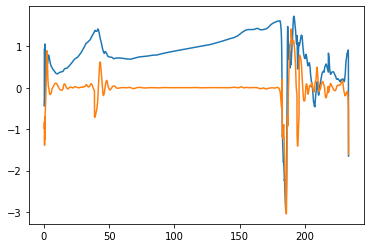

In [6]:
from ipywidgets import interact, interactive, fixed
import ipywidgets
import matplotlib.pyplot as plt
gym = env

xs = []
ys = []
f1s = []
f2s = []
rewards = []
ts = []
dts = []
scores = [0]
vels = []
xsm = []
ysm = []
omegas = []
for d in gym.history:
    gym.set_state(d['state'])
    xs.append(gym.drone.pos.x)
    ys.append(gym.drone.pos.y)
    omegas.append(gym.drone.omega)
    f1, f2 = d['actions']
    f1s.append(f1)
    f2s.append(f2)
    ts.append(gym.time_curr)
    rewards.append(d['reward'])
    dts.append(d['delta_t1'])
    scores.append(scores[-1]+d['reward'])
    vels.append(gym.drone.vel.len())
    xsm.append(gym.missile.pos.x)
    ysm.append(gym.missile.pos.y)
scores = scores[1:]
i1=0
i2=-1
# plt.plot(ts[i1:i2], rewards[i1:i2])
plt.plot(ts[i1:i2], f1s[i1:i2])
plt.plot(ts[i1:i2], f2s[i1:i2])
# plt.plot(ts[i1:i2], dts[i1:i2])

In [7]:
@interact(i=ipywidgets.IntSlider(min=0,max=len(gym.history)-1,step=1, value=0),
         ideal_traj=ipywidgets.Checkbox(value=True, description ='(зел) оценка траетктории до цели'),
         drone_traject=ipywidgets.Checkbox(value=True, description ='(синяя) траектория дрона '),
         missile_traject=ipywidgets.Checkbox(value=True, description ='(красная) траектория ракеты '))
def plot_history(i,ideal_traj,drone_traject, missile_traject):
    d = gym.history[i]
    i1=max(0,i-300)
    i2=i+1
    gym.set_state(d['state'])
    fig, (ax, ax2, ax3) = plt.subplots(1,3, figsize=(14,7))
    gym.plot(ax, drone_mashtb=150, vec_mashtb=10, actions=d['actions'],
             ideal_traj=ideal_traj, missile_d=True, missile_vec_mshtb=10)
    if drone_traject:
        ax.plot(xs[i1:i],ys[i1:i],ls=':',c='blue')
    if missile_traject:
        ax.plot(xsm[i1:i],ysm[i1:i],ls=':',c='red')
    ax.set_aspect('equal', adjustable='box')
    
    
#     ax2.plot(ts[i1:i2], f1s[i1:i2])
#     ax2.plot(ts[i1:i2], f2s[i1:i2])
    ax2.grid()
    ax2.plot(ts[:i2], vels[:i2])
#     ax2.plot(ts[:i2], omegas[:i2])
    
    ax3.plot(ts[:i2], rewards[:i2])
    ax3.grid()
    ax.grid()
    plt.show()

interactive(children=(IntSlider(value=0, description='i', max=2332), Checkbox(value=True, description='(зел) о…

In [8]:
info

{'result': 'success',
 'final_reward': 12.740374936708925,
 'pos_diff': 0.3527402983700645,
 'dir_diff': 0.17739891879456804,
 'vel_diff': 2.804464488733956}

In [12]:
gym.vel_trg

Vec2(0.48419508398869293, -8.734778978348654)